# Predict ED_dispo with result from Lbl2TransformerVec and without

For architecture and weight initialization, we will compare:

• BERT (baseline)

• <b> BioBERT

• Clinical BioBERT

• BlueBERT

• XLNet (baseline)

• Clinical XLnet

In [1]:
#!pip install tensorflow_hub

In [2]:
#!pip install tensorflow-text --no-dependencies

In [3]:
import pandas as pd
import numpy as np
import gc
import os
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import re
import tensorflow as tf
from transformers import TFXLNetModel, XLNetTokenizer
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import ParameterSampler
import tensorflow_hub as hub
import json
import csv 

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import mlflow
import mlflow.keras
import tensorflow_text as text
import seaborn as sns
from sentence_transformers import SentenceTransformer

2023-03-15 18:00:10.370653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 18:00:10.537424: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 18:00:11.182361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/cuda/efa/lib:/usr/local/cuda

In [4]:
#!pip install mlflow
#!databricks configure --host https://community.cloud.databricks.com/

In [5]:
torch.cuda.empty_cache()
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


2023-03-15 18:00:12.866997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 18:00:13.070129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:13.073720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:13.075565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)
tf.device('/device:GPU:0')

Num GPUs Available:  1


2023-03-15 18:00:15.109281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:15.110198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:15.110930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:15.112160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:15.112944: I tensorflow/compiler/xla/stream_executo

r/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:15.114455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:15.115200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 18:00:15.115904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13235 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [7]:
%env  DATABRICKS_USERNAME= 'xxxx' 
%env  DATABRICKS_PASSWORD = 'Projectcs224*'

env: DATABRICKS_USERNAME='karengar@stanford.edu'
env: DATABRICKS_PASSWORD='Projectcs224*'


 - Import data

In [8]:
data_test = pd.read_csv('/root/data/ed_test.csv')
data_train = pd.read_csv('/root/data/ed_train.csv')
data_val = pd.read_csv('/root/data/ed_val.csv')
data_val.head()

Unnamed: 0           CSN  Rads_order_ID                   Study  \
0       80343  131318610796      755426017   XR ELBOW 3 VIEWS LEFT   
1       66645  131314132694      741821327         XR CHEST 1 VIEW   
2       76374  131317332223      751367975         XR CHEST 1 VIEW   
3       66912  131314275465      742214156         XR CHEST 1 VIEW   
4      118086  131329544269      789721134  CT HEAD WO IV CONTRAST   

                                          Impression            ED_dispo  
0  1.  No displaced fracture or traumatic malalig...           Discharge  
1  1.  Apparent retrocardiac opacity favored to b...  Admit to Inpatient  
2              1.  No acute cardiopulmonary disease.           Discharge  
3  1.  Interval improvement in aeration of the ri...  Admit to Inpatient  
4  1.  No acute intracranial abnormality. 2.  Sca...           Discharge

In [9]:
#result_l2v = pd.read_csv('/root/Project-CS224N-ED-Disposition/result_l2v_v1.csv') 
#result_l2v.head()

In [10]:
def plot_roc_curve(y_proba, y_test, labels, mlflow, split_type):
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    fig = plt.figure(figsize = (17, 8))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}
    for i in range(len(labels)):
        # Gets the class
        c = labels[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_proba[:, i]
        df_aux = df_aux.reset_index(drop = True)

        # Plots the probability distribution for the class and the rest
        fig_upper = plt.subplot(2, 4, i+1)
        x = df_aux[df_aux['class'] ==0]
        plt.hist(x['prob'], density=True, label='Rest')
        y = df_aux[df_aux['class'] ==1]
        plt.hist(y['prob'], density=True, label=f" {c}", bins = bins)
        plt.title(c)
        plt.legend(loc='upper right')
        plt.xlabel(f"P(x = {c})")
        #plt.show()
        #mlflow.log_figure(fig, f"Histogram: {c}.png") 


        # Calculates the ROC Coordinates and plots the ROC Curves
        fpr, tpr, thresholds = roc_curve(df_aux['class'], df_aux['prob'], pos_label=1)
        mauc = auc(fpr, tpr)
        fig_bottom = plt.subplot(2, 4, i+5)
        plt.title( f"ROC: {c}")
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % mauc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        #plt.show()
        mlflow.log_metric("auc_" + split_type + "_"+  c, mauc) 

    plt.tight_layout()
    mlflow.log_figure(fig, "Hist_and_ROC_" + c+ "_"+ split_type + ".png") 
    
def evaluate(y_test, y_pred, mlflow,  split_type):
    """
    Evaluation function. For each of the text in evaluation data, it reads the score from
    the predictions made. And based on this, it calculates the values of
    True positive, True negative, False positive, and False negative.

    :param y_test: true labels
    :param y_pred: predicted labels
    :param labels: list of possible labels
    :return: evaluation metrics for classification like, precision, recall, and f_score
    """
     
    b = np.zeros_like(y_pred)
    b[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
    y_proba = y_pred

    y_pred = pd.DataFrame(b, columns = list(y_test.columns))
    y_pred = y_pred.idxmax(axis=1)
    y_test = y_test.idxmax(axis=1)

    labels = list(y_test.unique())
    labels = sorted(labels)

    plot_roc_curve(y_proba, y_test, labels, mlflow, split_type)

    matrix = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = matrix.diagonal()/matrix.sum(axis=1)
    for i, accu in enumerate(accuracy):
        mlflow.log_metric("accu_" + split_type + "_"+  labels[i] , accu) 
    
    # importing accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average= None)
    recall = recall_score(y_test, y_pred, average= None)
    f1score = f1_score(y_test, y_pred, average= None)


    report = classification_report(y_test, y_pred, target_names = labels)
    print(report)
    f_name = 'report_ '+ split_type +'.yaml'
    mlflow.log_dict(report, f_name)
    #mlflow.log_metric("auc_" + split_type, mauc) 
    mlflow.log_metric("accuracy_"+ split_type, accuracy)
   

    return accuracy, precision, recall, f1score




def mlflow_log_parameters(parameter):
    # Log parameters
    mlflow.log_param("dropout", parameter['dropout'])
    mlflow.log_param("learning_rate", parameter['learning_rate'])
    mlflow.log_param("epochs", parameter['epochs'])
    mlflow.log_param("batch_size", parameter['batch_size'])



def get_inputs_biobert(sentences):
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    # Load model from HuggingFace Hub
    tokenizer = AutoTokenizer.from_pretrained('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')
    model = AutoModel.from_pretrained('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')

    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling. In this case, mean pooling.
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings

def create_bert(bert, learning_rate=1e-3, dropout=0.1):
    input_ids = tf.keras.layers.Input(shape=(158,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(shape=(158,), dtype=tf.int32, name="attention_mask")

    embeddings = bert(input_ids, attention_mask = input_mask)[0]
    bert.trainable = False
    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    y = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(out)

    # Compile model
    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', 
               metrics=[tf.keras.metrics.AUC(), 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


def training_test_mae( mlflow, history):
    # Plot training and test loss at each epoch 
    fig, ax = plt.subplots()
    ax.plot(history.history['accuracy'], label='Training acc')
    #plt.plot(history.history['val_accuracy'], label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    mlflow.log_figure(fig, "training_validation_accuracy.png") 

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    mlflow.log_figure(fig, "training_validation_loss.png") 


# Scenario 1

- Without using results from l2v

In [11]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/karengar@stanford.edu/Bio_BERT_l2v")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3177290448991554', creation_time=1678627629649, experiment_id='3177290448991554', last_update_time=1678902978092, lifecycle_stage='active', name='/Users/karengar@stanford.edu/Bio_BERT_l2v', tags={'mlflow.experiment.sourceName': '/Users/karengar@stanford.edu/Bio_BERT_l2v',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'karengar@stanford.edu',
 'mlflow.ownerId': '3913783827154434'}>

In [12]:
#data[list(result_l2v.iloc[:, 3:].columns)] = result_l2v.iloc[:, 3:]
#data.head()

In [13]:
X_train = data_train.drop(['Unnamed: 0', 'ED_dispo', 'CSN', 'Rads_order_ID'], axis=1)
X_test =  data_test.drop(['Unnamed: 0', 'ED_dispo', 'CSN', 'Rads_order_ID'], axis=1)
X_val = data_val.drop(['Unnamed: 0', 'ED_dispo', 'CSN', 'Rads_order_ID'], axis=1)

# Assigning numerical values and storing in another column
y_train =  pd.get_dummies(data_train['ED_dispo'])
y_test = pd.get_dummies(data_test['ED_dispo'])[list(y_train.columns)]
y_val =  pd.get_dummies(data_val['ED_dispo'])[list(y_train.columns)]



In [14]:
del data_train, data_test, data_val 

In [15]:
rng = np.random.RandomState(0)
param_dist = {    'dropout': [0.1,0.2, 0.3],
                  'learning_rate': loguniform.rvs(1e-3, 1e-1, size= 10),
                  'epochs': [1],#, 5, 10, 25],
                  'batch_size':[64, 128]
                  }
            
dict_parameters = ParameterSampler(param_distributions=param_dist, n_iter= 1, random_state=rng)


In [16]:
tokenizer = AutoTokenizer.from_pretrained("AdwayK/biobert_ncbi_disease_ner_tuned_on_TAC2017")
bert = TFAutoModel.from_pretrained("AdwayK/biobert_ncbi_disease_ner_tuned_on_TAC2017")


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


2023-03-15 18:00:16.281285: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.281326: I tensorflow/core/common_runtime/placer.cc:114] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.281337: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.528456: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.528489: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.530506: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.530539: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:G

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:loc

2023-03-15 18:00:16.831063: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:16.831106: I tensorflow/core/common_runtime/placer.cc:114] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.831116: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.839031: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:16.839064: I tensorflow/core/common_runtime/placer.cc:114] Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.839071: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:16.842846: I tensorflow/core/common_runtime/placer.cc:114] dims: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessTruncatedNormalV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerCon

2023-03-15 18:00:17.587287: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:17.587328: I tensorflow/core/common_runtime/placer.cc:114] bias: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:17.587342: I tensorflow/core/common_runtime/placer.cc:114] BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:17.587372: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:17.609903: I tensorflow/core/common_runtime/placer.cc:114] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:17.609937: I tensorflow/core/common_runtime/placer.cc:114] perm: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:17.609947: I tensorflow/core/common_runtime/placer.cc:114] Transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:17.609

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:loca

2023-03-15 18:00:19.628545: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:19.628579: I tensorflow/core/common_runtime/placer.cc:114] begin: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:19.628588: I tensorflow/core/common_runtime/placer.cc:114] end: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:19.628596: I tensorflow/core/common_runtime/placer.cc:114] strides: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:19.628608: I tensorflow/core/common_runtime/placer.cc:114] StridedSlice: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:19.628617: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:19.644175: I tensorflow/core/common_runtime/placer.cc:114] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

2023-03-15 18:00:20.033838: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:20.033878: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:20.033890: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:20.037531: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:20.037567: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:20.037579: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:20.041217: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Some layers from the model checkpoint at AdwayK/biobert_ncbi_disease_ner_tuned_on_TAC2017 were not used when initializing TFBertModel: ['classifier', 'dropout_189']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at AdwayK/biobert_ncbi_disease_ner_tuned_on_TAC2017 and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
X_train = tokenizer(
    text=X_train['Impression'].tolist(),
    add_special_tokens=True,
    max_length=158,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=X_test['Impression'].tolist(),
    add_special_tokens=True,
    max_length=158,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val = tokenizer(
    text=X_val['Impression'].tolist(),
    add_special_tokens=True,
    max_length=158,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0


{'learning_rate': 0.007808662871552823, 'epochs': 1, 'dropout': 0.3, 'batch_size': 64}
Training
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

2023-03-15 18:00:41.278103: I tensorflow/core/common_runtime/placer.cc:114] shape: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:41.278145: I tensorflow/core/common_runtime/placer.cc:114] key: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:41.278156: I tensorflow/core/common_runtime/placer.cc:114] counter: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:41.278165: I tensorflow/core/common_runtime/placer.cc:114] alg: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:41.278177: I tensorflow/core/common_runtime/placer.cc:114] StatelessRandomUniformV2: (StatelessRandomUniformV2): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:41.278186: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:41.283408: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/repli

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


2023-03-15 18:00:41.679920: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:41.679957: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:41.679967: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:41.685241: I tensorflow/core/common_runtime/placer.cc:114] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:41.685274: I tensorflow/core/common_runtime/placer.cc:114] AnonymousIteratorV3: (AnonymousIteratorV3): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:41.689226: I tensorflow/core/common_runtime/placer.cc:114] dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:41.689257: I tensorflow/core/common_runtime/placer.cc:114] iterator: (_Arg): /job:localhost/replica

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localh

2023-03-15 18:00:51.610831: I tensorflow/core/common_runtime/placer.cc:114] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:00:51.610880: I tensorflow/core/common_runtime/placer.cc:114] model_tf_bert_model_bert_embeddings_gather_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.610896: I tensorflow/core/common_runtime/placer.cc:114] model_tf_bert_model_bert_embeddings_gather_1_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.610905: I tensorflow/core/common_runtime/placer.cc:114] model_tf_bert_model_bert_embeddings_gather_2_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.610913: I tensorflow/core/common_runtime/placer.cc:114] model_tf_bert_model_bert_embeddings_layernorm_batchnorm_mul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.610921: I tensorflow/core/common_runtime/placer.cc:114] model_tf_bert_model_b

/job:localhost/replica:0/task:0/device:CPU:0
OptionsDataset: (OptionsDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
AnonymousIteratorV3: (AnonymousIteratorV3): /job:localhost/replica:0/task:0/device:CPU:0
dataset: (_Arg): /job:localho

ensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/moments/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.676755: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/moments/Shape_2: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.676772: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/moments/Prod: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.676783: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/moments/Prod_1: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.676793: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/mom

/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/add/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/Square: (Square): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/Neg: (Neg): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/Exp: (Exp): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/truediv/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_

a:0/task:0/device:GPU:0
2023-03-15 18:00:51.676912: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/batchnorm/mul/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.676922: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/batchnorm/mul/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.676933: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/batchnorm/mul/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.676943: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/batchnorm/mul/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.676964: I tensorflow/core/common_runtime/placer.cc

l/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/sub/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/sub/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/sub/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/sub/Neg: (Neg): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/sub/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/sub/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder

time/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/moments/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677195: I tensorflow/core/common_runtime/placer.cc:114] AddN_71: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677206: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/add/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677223: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/add/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677233: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/add/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677243: I tensorflow/core/

alhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/mul/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/mul/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/mul/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/RsqrtGrad: (RsqrtGrad): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/Shape_3: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/BroadcastTo_1: (BroadcastTo): /job:localhost/replica:0/task:0/device:GPU:0

odel/tf_bert_model/bert/encoder/layer_._1/output/dropout_6/dropout/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677340: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/dropout_6/dropout/SelectV2_1: (SelectV2): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677351: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/dropout_6/dropout/BroadcastGradientArgs_1: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677360: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/dropout_6/dropout/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677369: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/dropout_6/dropout/Reshape_1: (R

rt/encoder/layer_._1/attention/output/dense/Tensordot/MatMul/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/transpose/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/Resha

U:0
2023-03-15 18:00:51.677512: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul_1/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677521: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677531: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul_1/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677541: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul_1/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677550: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_.

f/Add/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Tensordot/MatMul/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Tensordot/MatMul/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/truediv/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/truediv/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/truediv/RealDiv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/truediv/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/m

_1/intermediate/Gelu/mul_1/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677560: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul_1/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677567: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677576: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677583: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-

lica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/strided_slice_1: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Te

ore/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/Square: (Square): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677655: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/Neg: (Neg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677661: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/Exp: (Exp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677666: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677673: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/truediv/Shape: (Shape): /job:localhost/replica:0/ta

rt/encoder/layer_._1/attention/self/key/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/key/Tensordot/transpose/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
AddN_76: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/add_1/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/add_1/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/add_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/add_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:

/output/LayerNorm/batchnorm/add_1/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677871: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/add_1/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677883: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/mul_1/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677890: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/mul_1/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.677896: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/mul_1/BroadcastGra

rm/batchnorm/sub/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/Reshape: (Reshape): /job:localhost/replica:0/

nsorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/Maximum: (Maximum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678085: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/floordiv: (FloorDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678091: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/Cast: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678097: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678103: I tensorflow/core/common_runtime/placer.cc:114] AddN_74: (AddN): /job:localh

pe/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/Shape_6: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/Shape_7: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/Sum: (Sum): /job:localhost/replica:0/task:0/d

/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/mul/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678162: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/RsqrtGrad: (RsqrtGrad): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678168: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/Shape_3: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678175: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/BroadcastTo_1: (BroadcastTo): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678181: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_mo

evice:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
AddN_78: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/Sum_1: (Sum): /job:localhost/rep

7: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678243: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678249: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/Shape_6: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678255: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/Shape_7: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678261: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/b

/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/dense/Tensordot/transpose/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1/Res

ert/encoder/layer_._1/attention/output/LayerNorm/moments/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678268: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678274: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678280: I tensorflow/core/common_runtime/placer.cc:114] AddN_75: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678287: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/add/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678293: I tensorflo

oder/layer_._0/intermediate/Gelu/truediv/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/truediv/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/truediv/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
AddN_79: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/BiasAdd/BiasAddGrad: (BiasAddGrad): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/MatMul/

_1: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678427: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678434: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678439: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678445: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/transpose/transpose: (Transpose): /job:localhost/rep

dense/Tensordot/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/transpose/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
AddN_80: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/add_1/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/add_1/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/add_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/devic

ce): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678507: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul_1/strided_slice_1: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678513: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678519: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678527: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul_1/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678533: I

bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/sub/Neg: (Neg): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/sub/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/sub/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/mul_2/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/mul_2/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/mul_2/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/e

runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Tensordot/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678670: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Tensordot/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678677: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/Add/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678683: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/Add/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:51.678691: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/Add/BroadcastGradientAr

ments/Maximum_1: (Maximum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/floordiv_1: (FloorDiv): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Cast_1: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/truediv_1: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradi

61: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/strided_slice_1: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:52.069269: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:52.069276: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:52.069282: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/MatMul/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:52.069289: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/b

plica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/SelectV2_1: (SelectV2): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tap

2.069346: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/Reshape_2: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:52.069353: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/Shape_3: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.074451: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/Reshape_3: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.074490: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/BiasAdd/BiasAddGrad: (BiasAddGrad): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.074502: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention

e/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/BroadcastGradientArgs_1: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/BiasAdd/BiasAddGrad: (BiasAddGrad): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/Tensordot/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_.

03-15 18:00:53.074547: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/MatMul/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.074553: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/MatMul/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.074560: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/key/Tensordot/MatMul/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.074566: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/attention/self/key/Tensordot/MatMul/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.074572: I tensorflow/core/common_runtime/placer.c

atMul/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/Tensordot/MatMul/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/Tensordot/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/Tensordot/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/Tensordot/transpose/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Shape: (Shape): /job:localhost/re

ent_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/add_1/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.835960: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/add_1/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.835966: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/add_1/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.835973: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_1/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:53.835979: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_1

plica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/transpose_3/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/transpose_3/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/MatMul: (BatchMatMulV2): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/MatMul_1: (BatchMatMulV2): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/

del/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/sub/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:54.180539: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/sub/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:54.180546: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/sub/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:54.180552: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/sub/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:54.180558: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnor

self/MatMul_1/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/strided_slice: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/strided_slice_1: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_

odel/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:55.370965: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:55.370996: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul_2/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:55.371011: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:55.371021: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/BroadcastTo: (BroadcastTo): /jo

host/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Add/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/MatMul/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/MatMul/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/truediv/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/truediv/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/truediv/RealDiv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/

ayer_._0/output/LayerNorm/batchnorm/mul/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:55.784014: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:55.784049: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:55.784059: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:55.784066: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/batchnorm/mul/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU

ttention/self/truediv/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul/MatMul: (BatchMatMulV2): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul/MatMul_1: (BatchMatMulV2): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_

k:0/device:GPU:0
2023-03-15 18:00:56.310474: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/moments/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:56.310481: I tensorflow/core/common_runtime/placer.cc:114] AddN_78: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:56.310488: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:56.310494: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:56.310501: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/add/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/rep


gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Shape_3: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Reshape_3: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/BiasAdd/BiasAddGrad: (BiasAddGrad): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/BiasAdd/BiasAddGrad: (BiasAddGrad): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/Tensordot/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/Tensordot/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/Shape: (Shape): /job:

_bert_model/bert/encoder/layer_._0/output/dropout_3/dropout/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.135831: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/dropout_3/dropout/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.135837: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/dense/BiasAdd/BiasAddGrad: (BiasAddGrad): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.135846: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/dense/Tensordot/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.135853: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/output/dense/Tensordot/Reshape: (Reshape): /job:localhost/replica:0/task:0/device

t_model/bert/encoder/layer_._0/attention/self/query/Tensordot/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/Tensordot/transpose/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert

 gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/add/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.224734: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/add/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.224740: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/add/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.224746: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/add/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.224753: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul: (Mul): /job:localhost

/batchnorm/mul_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/

:GPU:0
2023-03-15 18:00:57.998294: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/truediv/Neg: (Neg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998301: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/truediv/RealDiv_1: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998307: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/truediv/RealDiv_2: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998313: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/truediv/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998319: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model

job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_2/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_2/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_2/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_2/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_2/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_2/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_2/Mul_1: (Mul): /job:localhost

/bert/encoder/layer_._0/intermediate/Gelu/truediv/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998325: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/truediv/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998336: I tensorflow/core/common_runtime/placer.cc:114] AddN_79: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998343: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/BiasAdd/BiasAddGrad: (BiasAddGrad): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998349: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:57.998356: I tensorflow/core/common_runtime/placer.cc:

calhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/floordiv: (FloorDiv): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/Cast: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
AddN_84: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchn

ensordot/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:58.720226: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:58.720233: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/transpose/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:58.720240: I tensorflow/core/common_runtime/placer.cc:114] AddN_80: (AddN): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:58.720247: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/batchnorm/add_1/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:58.720253: I tensorflow/core/commo

BroadcastTo): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/Shape_4: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/Shape_5: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/Prod_2: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/Prod_3: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/Maximum_1: (Maximum): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/floordiv_1: (FloorDiv): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/Cast_1: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/

oder/layer_._0/attention/output/LayerNorm/moments/BroadcastTo: (BroadcastTo): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:59.310362: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:59.310368: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Shape_2: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:59.310376: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Prod: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:00:59.310382: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Prod_1: (Prod): /job

ddings/Gather_2/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/strided_slice: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/concat: (ConcatV2): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather/Size: (Size): /job:localhost/replica:0/task:0/device:CPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather/strided_slice: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert

sorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Shape_4: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.061580: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Shape_5: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.061588: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Prod_2: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.061594: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/Prod_3: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.061600: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/ber

_4: (AssignAddVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
sub_2: (Sub): /job:local

ost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.671336: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/add/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.671343: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/add/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.671349: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/add/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.671378: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/output/add/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:00.671385: I tensorflow/core/common_runtime/placer.cc:1

host/replica:0/task:0/device:GPU:0
AssignAddVariableOp_5: (AssignAddVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
sub_3: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
AssignAddVariableOp_6: (AssignAddVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
group_deps: (NoOp): /job:localhost/replica:0/task:0/device:GPU:0
Cast_6: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
ArgMax: (ArgMax): /job:localhost/replica:0/task:0/device:GPU:0
Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
ArgMax_1: (ArgMax): /job:localhost/replica:0/task:0/device:GPU:0
Equal: (Equal): /job:localhost/replica:0/task:0/device:GPU:0
Cast_7: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
Sum_4: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
AssignAddVariableOp_7: (AssignAddVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
Size: (Size): /job:localhost/replica:0/task:0/device:GPU:0
Cast_8: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
AssignAddVariab

bert/encoder/layer_._0/attention/self/MatMul_1/strided_slice: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:01.716396: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/strided_slice_1: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:01.716403: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:01.716409: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:01.716415: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul_1/Reshape: (Reshape): /

leOp_8: (AssignAddVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
Cast_9: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
Shape_2: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_1: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_2: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
Prod: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
SelectV2: (SelectV2): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_2: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
Cast_11: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_3: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
mul_5: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_4: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
stack: (Pack): /job:localhost/replica:0/task:0/device:GPU:0
Tile: (Tile): /job:localhost/replica:0/task:0/device:GPU:0
Tile_1: (Tile): /job:localhost/replica:0/task:0/device:GPU:0
Greater: (Greate

InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.033378: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/transpose_1/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.033385: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/dropout_1/dropout/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.033392: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.033398: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.463909: I tensorf

st/replica:0/task:0/device:GPU:0
AssignAddVariableOp_11: (AssignAddVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
LogicalAnd_3: (LogicalAnd): /job:localhost/replica:0/task:0/device:GPU:0
Cast_18: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
Sum_8: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
AssignAddVariableOp_12: (AssignAddVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
group_deps_2: (NoOp): /job:localhost/replica:0/task:0/device:GPU:0
div_no_nan/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
div_no_nan/ReadVariableOp_1: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
div_no_nan: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
Identity_2: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Add/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
Add/ReadVariableOp_1: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
Add: (AddV2): /job:localhost/repli

_bert_model/bert/encoder/layer_._0/attention/self/Add/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.464009: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Add/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.464015: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/Add/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.464021: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/MatMul/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.464027: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/MatMul/MatMul_1: (MatMul): /j

0/task:0/device:GPU:0
sub_4: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
Mul_7: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
auc: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
Identity_3: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
div_no_nan_3/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
div_no_nan_3/ReadVariableOp_1: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
div_no_nan_3: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
Identity_4: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Add_3/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
Add_3/ReadVariableOp_1: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
Add_3: (AddV2): /job:localhost/replica:0/task:0/device:GPU:0
div_no_nan_4/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
div_no_nan_4: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
strided_slic

ime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/truediv/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.681738: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/truediv/Neg: (Neg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.681746: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/truediv/RealDiv_1: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.681754: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/truediv/RealDiv_2: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:02.681760: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/truediv/mul: (Mul): /job:loca

alhost/replica:0/task:0/device:GPU:0
Identity_10: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Identity_11: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
identity_7_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
identity_8_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
identity_9_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
identity_10_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
identity_11_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/Fill/dims/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/Fill/value: (Const): /job

ow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:03.243232: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/MatMul/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:03.243241: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/transpose/InvertPermutation: (InvertPermutation): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:03.243249: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/transpose/transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:03.243257: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_b

U:0
model/tf_bert_model/bert/strided_slice_1/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/d

c:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/BiasAdd/BiasAddGrad: (BiasAddGrad): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:03.243326: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/Tensordot/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:03.243332: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/Tensordot/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:03.243338: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:03.897674: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensord

evice:GPU:0
model/tf_bert_model/bert/Reshape/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/Reshape/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/query/Tensordot/free: (Cons

l/tf_bert_model/bert/embeddings/dropout/dropout/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.398528: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/dropout/dropout/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.398546: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/dropout/dropout/SelectV2_1: (SelectV2): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.398558: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/dropout/dropout/BroadcastGradientArgs_1: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.398565: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/dropout/dropout/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.398571: I tensorflo

job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention

t_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.398645: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.398655: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.398664: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.777771: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 

/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/value/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/self/Reshape_1/sha

pe: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.777836: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/sub/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.777843: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/sub/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.777850: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/sub/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.777856: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/sub/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:04.777862: I tensorflow/core/common_runtime/pla

: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/output/dropout_2/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/attention/ou

ime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:05.274643: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:05.274649: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:05.274655: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:05.851962: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/mul/Reshape: (Reshape): /job:localhost/re

:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/add/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._0/output/dense/Tensordo

rflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add_1/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510470: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add_1/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510477: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add_1/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510483: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add_1/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510489: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add_1/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510495: I tensorfl

ention/self/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/concat/ax

ow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add_1/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510502: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add/Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510508: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510515: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510522: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/embeddings/add/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:06.510528: I tensorflow/core

bert/encoder/layer_._1/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/outp

e): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.296357: I tensorflow/core/common_runtime/placer.cc:114] Mul_2: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.296363: I tensorflow/core/common_runtime/placer.cc:114] sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.296369: I tensorflow/core/common_runtime/placer.cc:114] Mul_3: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.296376: I tensorflow/core/common_runtime/placer.cc:114] mul_4: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.296382: I tensorflow/core/common_runtime/placer.cc:114] Ceil: (Ceil): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.296389: I tensorflow/core/common_runtime/placer.cc:114] sub_1: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.296398: I tensorflow/core/common_runtime/placer.cc:114] Relu: (Relu): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-

model/bert/encoder/layer_._1/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dropout_5/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dropout_5/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/dropout_5/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
mod

ime/placer.cc:114] mul_5: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.663448: I tensorflow/core/common_runtime/placer.cc:114] Reshape_4: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.663455: I tensorflow/core/common_runtime/placer.cc:114] stack: (Pack): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.663462: I tensorflow/core/common_runtime/placer.cc:114] Tile: (Tile): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.663468: I tensorflow/core/common_runtime/placer.cc:114] Tile_1: (Tile): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:07.663474: I tensorflow/core/common_runtime/placer.cc:114] Greater: (Greater): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340758: I tensorflow/core/common_runtime/placer.cc:114] Tile_2: (Tile): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340794: I tensorflow/core/common_runtime/placer.cc:114] LogicalNot: (Logi

el/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/b

core/common_runtime/placer.cc:114] Prod_1: (Prod): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340913: I tensorflow/core/common_runtime/placer.cc:114] SelectV2_1: (SelectV2): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340919: I tensorflow/core/common_runtime/placer.cc:114] Reshape_5: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340925: I tensorflow/core/common_runtime/placer.cc:114] Cast_16: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340933: I tensorflow/core/common_runtime/placer.cc:114] Reshape_6: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340942: I tensorflow/core/common_runtime/placer.cc:114] mul_6: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340951: I tensorflow/core/common_runtime/placer.cc:114] Reshape_7: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.340961: I tensorflow/core/common_runt

ert/encoder/layer_._1/intermediate/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/mul/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/add/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._1/output/dense/Tensordot/axes: (Const): /job:localhost/replica:

flow/core/common_runtime/placer.cc:114] group_deps_2: (NoOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.458845: I tensorflow/core/common_runtime/placer.cc:114] div_no_nan/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.458851: I tensorflow/core/common_runtime/placer.cc:114] div_no_nan/ReadVariableOp_1: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.458858: I tensorflow/core/common_runtime/placer.cc:114] div_no_nan: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.458867: I tensorflow/core/common_runtime/placer.cc:114] Identity_2: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.458875: I tensorflow/core/common_runtime/placer.cc:114] Add/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.458883: I tensorflow/core/common_runtime/placer.cc:114] Add/ReadVariableOp_1: (ReadVariabl

tention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape/shape/2: (Const): /job:l

ariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.890927: I tensorflow/core/common_runtime/placer.cc:114] div_no_nan_3: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.890936: I tensorflow/core/common_runtime/placer.cc:114] Identity_4: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.890945: I tensorflow/core/common_runtime/placer.cc:114] Add_3/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.890952: I tensorflow/core/common_runtime/placer.cc:114] Add_3/ReadVariableOp_1: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.890959: I tensorflow/core/common_runtime/placer.cc:114] Add_3: (AddV2): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.890964: I tensorflow/core/common_runtime/placer.cc:114] div_no_nan_4/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:08.89

ocalhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/transpose/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert

_runtime/placer.cc:114] Identity_8: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.324347: I tensorflow/core/common_runtime/placer.cc:114] Identity_9: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.324366: I tensorflow/core/common_runtime/placer.cc:114] Identity_10: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.324373: I tensorflow/core/common_runtime/placer.cc:114] Identity_11: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.324380: I tensorflow/core/common_runtime/placer.cc:114] identity_7_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.324387: I tensorflow/core/common_runtime/placer.cc:114] identity_8_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.324393: I tensorflow/core/common_runtime/placer.cc:114] identity_9_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:

r/layer_._2/attention/self/dropout_7/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/dropout_7/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/attention/output/dense/Tensordot/Gather

U:0
2023-03-15 18:01:09.704205: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/range/limit: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704212: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/range/delta: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704218: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/ExpandDims/dim: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704225: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704231: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704237: I tensor

eplica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/intermediate/Gelu/mul/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/intermediate/Gelu/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/intermediate/Gelu/add/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/Const: (Const)

flow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704244: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/dropout/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704250: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/dropout/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704257: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/embeddings/dropout/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704263: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/strided_slice_1/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:09.704268: I tensorflow/core/common_runtime/placer.cc:114] model/tf_be

(Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dropout_9/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dropout_9/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/dropout_9/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._2/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0

r_._0/attention/self/key/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:10.231873: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:10.231880: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:10.231886: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:10.231893: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attention/self/key/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:10.231899: I tensorflow/core/com

e/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/self/Reshape/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/self/transpose/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device

ob:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.174829: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.174835: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.174842: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.174849: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.174855: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/attent

ert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/attention/output/dropout_11/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/

:0/device:GPU:0
2023-03-15 18:01:11.835151: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.835161: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.835170: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.835180: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/intermediate/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:11.835189: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._0/intermediat

_bert_model/bert/encoder/layer_._3/intermediate/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/intermediate/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/intermediate/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/intermediate/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/intermediate/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/intermediate/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/intermediate/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._

mmon_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/query/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.561723: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/key/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.561732: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/key/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.561738: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/key/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.561745: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica

3/intermediate/Gelu/mul/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/intermediate/Gelu/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/intermediate/Gelu/add/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/ber

/bert/encoder/layer_._1/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.973361: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.973368: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.973375: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.973381: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:12.9733

el/bert/encoder/layer_._4/attention/self/key/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/key/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/key/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/key/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/key/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/key/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/key/

/self/Reshape_2/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:13.865494: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/Reshape_2/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:13.865529: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/transpose_2/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:13.865537: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:13.865545: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/self/add_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:13.865552: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_

/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/Reshape_1/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/attention/self/Reshape_1/shape/2: (Const

3-15 18:01:14.057338: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:14.057345: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:14.057352: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:14.057358: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:14.057365: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._1/intermediate/dense

/job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/intermediate/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/intermediate/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/intermediate/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/intermediate/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/intermediate/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/intermediate/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._4/intermediate/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0


self/key/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.002776: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.002783: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.002789: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.002795: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/key/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.002802: I tensorflow/core/common_runtime/plac

/bert/encoder/layer_._5/attention/self/key/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/key/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/key/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/key/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/Reshape/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/Reshape/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/transpose/perm: (Const):

ncoder/layer_._2/attention/self/value/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.233394: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/value/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.233401: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape_1/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.233407: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape_1/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.233412: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape_1/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.233419: I tensorflow/core/com

:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:

lica:0/task:0/device:GPU:0
2023-03-15 18:01:15.871222: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.871229: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.871235: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.871242: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:15.871251: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/attention/output/dense

0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
mo

rV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:16.148870: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:16.760489: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:16.760521: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:16.760528: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._2/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:16.760539: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encod

task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dropo

yer_._3/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:17.381878: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152201: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152234: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152246: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152256: I tensorflow

ert/encoder/layer_._5/output/dropout_18/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/dropout_18/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/se

shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152355: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/self/Reshape_2/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152364: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/self/transpose_2/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152374: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/self/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152383: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/self/add_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.152392: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/se

lf/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/concat/axis: (Cons

ice:GPU:0
2023-03-15 18:01:18.514117: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.514125: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.514133: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.514144: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:18.514152: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/attention

job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/value/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/value/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/Reshape_1/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/Reshape_1/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/Reshape_1/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/transpose_1/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/self/Reshape_2/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/be

3443: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447533: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447570: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447580: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447591: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._3/output/dropout_12/dropout/Const: (Const): /job:localhost/replica:0/task:0

del/bert/encoder/layer_._6/attention/output/dropout_20/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/intermediate/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/intermediate/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._6/intermediate/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_ber

._3/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447635: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447641: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447647: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447654: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447660: I tensorflow/core/common_runtime/placer

model/tf_bert_model/bert/encoder/layer_._7/attention/self/query/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/query/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/query/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/query/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/query/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/query/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encod

.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447666: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447672: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447678: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.447685: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device

er/layer_._7/attention/self/key/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:

eplica:0/task:0/device:GPU:0
2023-03-15 18:01:19.635651: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.925180: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.925216: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.925224: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/value/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:19.925231: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/

0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/Reshape/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self

:0/task:0/device:GPU:0
2023-03-15 18:01:19.925330: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:20.700757: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:20.700783: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:20.700791: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:20.700804: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/output/dense/Ten

/Reshape/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/transpose/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/Const_1: (Const): /job:localhost/re

placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:20.700844: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:20.700850: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:20.700857: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/output/dropout_14/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:20.700863: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/attention/output/dropout_14/dropout/GreaterEqual/y: (Const): /job:local

/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/output/dropout_23/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/attention/output/dropout_23/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/

V2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.162738: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.162749: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.162756: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.162762: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.162769: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encode

k:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/intermediate/Gelu/mul/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/la

lacer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.710760: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.710767: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._4/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.710774: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:21.710780: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/

ert_model/bert/encoder/layer_._7/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/output/dropout_24/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/output/dropout_24/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/output/dropout_24/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/output/LayerNorm/moment

lacer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/query/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051777: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/key/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051814: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/key/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051825: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/key/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051832: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/devi

s/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._7/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/query/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/query/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/query/Tensordot/GatherV2/axis: (Const): /job:localhost/r

layer_._5/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051926: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051932: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051939: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051945: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.051951: I tensorfl

attention/self/key/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/transpose/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replic

self/dropout_16/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.582574: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/dropout_16/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.582580: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/dropout_16/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.582586: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.582592: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:22.582600: I tensorflow/core/common_runtime/pl

f_bert_model/bert/encoder/layer_._8/attention/self/Reshape_1/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape_1/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/transpose_1/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape_2/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape_2/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape_2/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/transpose_2/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/self/Cast/x: (Const): /job:localhost/re

on/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:23.201353: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/output/dropout_17/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:23.201359: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/output/dropout_17/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:23.201365: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/output/dropout_17/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:23.201372: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._5/attention/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:

on/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/attention/ou

er.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.065361: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.065368: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.065375: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.065382: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/query/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/devi

ce:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/query/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/en

24.699891: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/Reshape/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.699897: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/transpose/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.699904: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.699911: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.699917: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost

model/bert/encoder/layer_._9/attention/self/key/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/transpose/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/value/Tensordot/GatherV2/axis: (

ca:0/task:0/device:GPU:0
2023-03-15 18:01:24.968929: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.968942: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.968949: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.968957: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:24.968964: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/output/dense/T

0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape_1/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape_1/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/transpose_1/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape_2/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape_2/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape_2/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/transpose_2/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/attention/self/Cast/

e/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:25.339094: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:25.339100: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:25.339107: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/output/dropout_20/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:25.339113: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._6/attention/output/dropout_20/dropout/GreaterEqual/y: (Const): /job:loc

): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/intermediate/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/mul/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/add/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._9/output/dense/T

/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/query/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:26.211047: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:26.211053: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:26.211059: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:26.211068: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/de

layer_._10/attention/self/query/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/query/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/query/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/query/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/query/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/query/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/query/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/sel

r/layer_._7/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.122870: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.122877: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.122883: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.122889: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.122895: I tensor

del/bert/encoder/layer_._10/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/value/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/value/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/value/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_.

placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.623633: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.623640: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.623646: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.623653: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0

layer_._10/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/attention/output/dense/Ten

tion/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.992500: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/output/dropout_23/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.992509: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/output/dropout_23/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.992515: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/output/dropout_23/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.992522: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/attention/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 1

se/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/intermediate/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/intermediate/dense/Tensord

rdot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.992564: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.992574: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.992581: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:27.992588: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._7/intermediate/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:28.273961: I tensorflow/core/common_runtime/placer.cc:1

ot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/intermediate/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/intermediate/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/intermediate/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/intermediate/Gelu/mul/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/intermediate/Gelu/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/intermediate/Gelu/add/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model

vice:GPU:0
2023-03-15 18:01:28.816650: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/query/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:28.816657: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/query/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:28.816663: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/query/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:28.816670: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/key/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:28.816676: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/sel

/bert/encoder/layer_._10/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/concat_1/axis: (Const): /job:

cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/key/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:29.127521: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/key/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:29.127528: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/key/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:29.127535: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:29.127543: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:0

self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/Reshape/shape/2: (Const): /job:lo

lica:0/task:0/device:GPU:0
2023-03-15 18:01:29.712224: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:29.712230: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:29.712236: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:29.712244: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:29.712253: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/attention/output/dense

/self/dropout_34/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/output/dense/Tensordot/GatherV2_1/axis: (Co

 (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624849: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/intermediate/Gelu/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624857: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/intermediate/Gelu/add/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624865: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624872: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624879: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/output/dense/Tensordot/Ga

st): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/output/dropout_35/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/intermediate/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/intermediate/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/intermediate/dense/Tensordot/GatherV2

coder/layer_._8/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624919: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624927: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/output/dropout_27/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624933: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/output/dropout_27/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624940: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._8/output/dropout_27/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:30.624946: I tensorflow/core/common_runti

model/tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/pooler/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/pooler/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/tf_bert_model/bert/pooler/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
model/global_max_pooling1d/Max/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/Rank: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/Rank_1: (Const): /job:lo

me/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/query/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:31.184675: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/key/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:31.184682: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/key/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:31.184689: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/key/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:31.184695: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/

ross_entropy_with_logits/Slice/size: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/concat/values_0: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/Rank_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/Sub_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/Slice_1/size: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/concat_1/values_0: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentrop

orflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/value/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:31.473192: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/value/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:31.473199: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/value/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:31.473205: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/value/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:31.473211: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape_1/shape/1: (Const): /job:local

y/softmax_cross_entropy_with_logits/Sub_2/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/softmax_cross_entropy_with_logits/Slice_2/begin: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/weighted_loss/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/weighted_loss/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/weighted_loss/Rank: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/weighted_loss/range/start: (Const): /job:localhost/replica:0/task:0/device:GPU:0
categorical_crossentropy/weighted_loss/range/delta: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Rank: (Const): /job:localhost/r

ape_2/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.104893: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/Reshape_2/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.104901: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/transpose_2/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.104908: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.104922: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/self/add_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.104931: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attent

ca:0/task:0/device:GPU:0
gradient_tape/categorical_crossentropy/weighted_loss/Reshape_1/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/categorical_crossentropy/softmax_cross_entropy_with_logits/ExpandDims/dim: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/categorical_crossentropy/softmax_cross_entropy_with_logits/ExpandDims_1/dim: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/global_max_pooling1d/Size: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/global_max_pooling1d/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/global_max_pooling1d/range/start: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/global_max_pooling1d/range/delta: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/global_max_pooling1d/ones/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/b

:0/device:GPU:0
2023-03-15 18:01:32.104996: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.105003: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.105009: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.105016: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/attention/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:32.671208: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/att

ntion/output/LayerNorm/moments/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/moments/Const_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/output/dropout_35/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/output/dropout_35/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/self/MatMul_1/strided_slice/stack: (Const): /job:localh

ommon_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:33.221254: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:33.221262: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:33.221270: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:33.221277: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01

t/encoder/layer_._10/output/LayerNorm/moments/Const_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/output/dropout_33/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/output/dropout_33/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/intermediate/Gelu/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/intermediate/Gelu/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/

:33.221284: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:33.221290: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:33.221297: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:33.221304: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:33.221310: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._9/output/dropout_30/dropout/Const: (Const): /job:localhost/replica:0/

calhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/output/dropout_32/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice_1/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice_1/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_t

114] model/tf_bert_model/bert/encoder/layer_._10/attention/self/value/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.147776: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/attention/self/value/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.147785: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/attention/self/Reshape_1/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.147795: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/attention/self/Reshape_1/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.147803: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/attention/self/Reshape_1/shape/3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18

ape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice_1/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/dropout_31/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/dropout_31/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul/strided_slic

t_31/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.461303: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/attention/self/transpose_3/perm: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.461310: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/attention/self/Reshape_3/shape/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.461316: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/attention/self/Reshape_3/shape/2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.461323: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/attention/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:34.461330: I tensorflow/core/common_runtime/placer.cc:114] model/tf_ber

device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/attention/self/MatMul/strided_slice_1/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/t

.cc:114] model/tf_bert_model/bert/encoder/layer_._10/intermediate/Gelu/mul/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.112639: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/intermediate/Gelu/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.112646: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/intermediate/Gelu/add/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.112653: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.112659: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/output/dense/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.112666: I tensorflow/core/common_runtime/pl

f_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/Maximum/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/Const_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gra

st/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.670651: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/moments/mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.670658: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/moments/variance/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.670664: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/batchnorm/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.670674: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.670683: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/ber

ost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/moments/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/moments/Const_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/dropout_26/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/dropout_26/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model

sorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/query/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902274: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/query/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902310: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/query/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902321: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/query/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902331: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/query/Tensordot/Const_2: (Const)

dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/self/dropout_25/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/self/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/self/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/self/MatMul/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/self/MatMul/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/self/MatMul/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model

ert/encoder/layer_._11/attention/self/key/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902385: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902395: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902402: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902409: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/key/Tensordot/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:35.902415:

bert_model/bert/encoder/layer_._7/attention/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/atte

/device:GPU:0
2023-03-15 18:01:35.902447: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/value/Tensordot/axes: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.183081: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/value/Tensordot/free: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.183109: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/value/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.183117: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/self/value/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.183124: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/at

ntion/output/dropout_23/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/output/dropout_23/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/MatMul_1/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/MatMul_1/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/MatMul_1/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/MatMul_1/strided_slice_1/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/MatMul_1/strided_slice_1/stack_1: (Const): /job:l

replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.866034: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/output/dense/Tensordot/concat_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.866040: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/output/dropout_35/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.866047: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/output/dropout_35/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.866053: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/attention/output/dropout_35/dropout/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:36.866059: I tensorflow/core/common_runtime/placer.cc:114] model/tf_b

ocalhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/MatMul_1/strided_slice_1/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/dropout_22/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/dropout_22/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._7/attention/self/MatMul/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/la

task:0/device:GPU:0
2023-03-15 18:01:37.438497: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/intermediate/dense/Tensordot/GatherV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:37.438511: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/intermediate/dense/Tensordot/GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:37.438518: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/intermediate/dense/Tensordot/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:37.438524: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/intermediate/dense/Tensordot/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:37.438531: I tensorflow/core/common_runtime/placer.cc:114] model/tf_bert_model/bert/encoder/layer_._11/

._6/intermediate/Gelu/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._6/intermediate/Gelu/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/moments/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/moments/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/moments/Maximum/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/moments/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/moments/Const_3: (Const): /job:localhost/replica:0/task:0/device:GP

(Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:39.740042: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/self/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:39.740052: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/self/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:39.740060: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/self/MatMul/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:39.740066: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._11/attention/self/MatMul/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:39.740073: I tensor

odel/tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/moments/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/moments/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/moments/Maximum/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/moments/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/moments/Const_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNo

ice:GPU:0
2023-03-15 18:01:40.034187: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:40.034217: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:40.034225: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/output/dropout_33/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:40.034233: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/output/dropout_33/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:40.034240: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_

rm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/output/dropout_14/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/output/dropout_14/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/self/MatMul_1/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/self/MatMul_1/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/self/MatMul_1/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._4/attention/self/MatMul_1/strided_slice_1/stack: (Const): /job:localhost/replica:0/task:0/

model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:40.994943: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice_1/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:40.994951: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice_1/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:40.994958: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/MatMul_1/strided_slice_1/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:40.994965: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._10/attention/self/dropout_31/

/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/output/dropout_12/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/intermediate/Gelu/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/intermediate/Gelu/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/attention/output/LayerNorm/moments/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/attention/output/LayerNorm/moments/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/attention/output/LayerNorm/moments/Maximum/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/attention/output/La

_tape/model/tf_bert_model/bert/encoder/layer_._9/output/dropout_30/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:41.260332: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:41.260339: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/intermediate/Gelu/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:41.260347: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/attention/output/LayerNorm/moments/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:41.260354: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/attention/output/LayerNorm/moments/Const_1: (Const): /job:localhos

tput/LayerNorm/moments/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/moments/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/moments/Maximum/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/moments/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/moments/Const_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/t

ow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/attention/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:41.260401: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/attention/output/dropout_29/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:41.260408: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/attention/output/dropout_29/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:41.260415: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._9/attention/self/MatMul_1/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:41.509273: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert

job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/self/dropout_7/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/self/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/self/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/self/MatMul/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/self/MatMul/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._2/attention/self/MatMul/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encode

acer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:42.084981: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:42.084988: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/dropout_26/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:42.084995: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/attention/output/dropout_26/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:42.706220: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._8/att

:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/moments/Const_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/dropout_6/dropout/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/output/dropout_6/dropout/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/encoder/layer_._1/intermediate/Gelu/truediv/Shape_1: (Const): /job:localhost/replica:0/task:

01:46.867587: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/moments/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:46.867598: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/moments/Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:46.867608: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/moments/Maximum/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:46.867617: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/moments/Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:46.867627: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_.

model/tf_bert_model/bert/embeddings/LayerNorm/moments/Maximum_1/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/LayerNorm/moments/scalar: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/ExpandDims/dim: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradient_tape/model/tf_bert_model/bert/embeddings/Gather_2/concat/axis: (Const): /job:localhos

:0
2023-03-15 18:01:47.164486: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/attention/self/truediv/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:47.164492: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/attention/self/MatMul/strided_slice/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:47.164498: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/attention/self/MatMul/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:47.667624: I tensorflow/core/common_runtime/placer.cc:114] gradient_tape/model/tf_bert_model/bert/encoder/layer_._3/attention/self/MatMul/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:47.667651: I tensorflow/core/common_runtime/placer.cc:114] gradient

   2/1599 [..............................] - ETA: 17:23 - loss: 4.4528 - auc: 0.6883 - accuracy: 0.4922 - precision: 0.4921 - recall: 0.4844   Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_25442 in device /job:localhost/replica:0/task:0/device:GPU:0


e_2/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:52.353749: I tensorflow/core/common_runtime/placer.cc:114] strided_slice_2/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:52.353756: I tensorflow/core/common_runtime/placer.cc:114] Prod/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:52.353762: I tensorflow/core/common_runtime/placer.cc:114] ones_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:52.353769: I tensorflow/core/common_runtime/placer.cc:114] Reshape_2/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:52.353775: I tensorflow/core/common_runtime/placer.cc:114] Reshape_3/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:52.353781: I tensorflow/core/common_runtime/placer.cc:114] Reshape_4/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:01:52.353787: I tensorflow/core

   3/1599 [..............................] - ETA: 17:31 - loss: 4.4942 - auc: 0.6825 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4948Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_25442 in device /job:localhost/replica:0/task:0/device:GPU:0


ir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-15 18:01:56.116238: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   4/1599 [..............................] - ETA: 17:32 - loss: 3.7949 - auc: 0.7115 - accuracy: 0.5117 - precision: 0.5118 - recall: 0.5078Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_25442 in device /job:localhost/replica:0/task:0/device:GPU:0
   5/1599 [..............................] - ETA: 17:29 - loss: 3.7185 - auc: 0.7015 - accuracy: 0.5219 - precision: 0.5220 - recall: 0.5188Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_25442 in device /job:localhost/replica:0/task:0/device:GPU:0
   6/1599 [..............................] - ETA: 17:29 - loss: 3.7105 - auc: 0.6861 - accuracy: 0.5182 - precision: 0.5183 - recall: 0.5156Executing op ReadVariableOp in device /job:localhost/repli

2023-03-15 18:19:43.982760: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:19:43.982798: I tensorflow/core/common_runtime/placer.cc:114] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:19:43.982806: I tensorflow/core/common_runtime/placer.cc:114] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:19:43.985730: I tensorflow/core/common_runtime/placer.cc:114] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:19:43.985760: I tensorflow/core/common_runtime/placer.cc:114] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:19:43.985768: I tensorflow/core/common_runtime/placer.cc:114] DivNoNan: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:19:43.985776: I tensorflow/core/common_runtime/placer.cc:114] z_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 

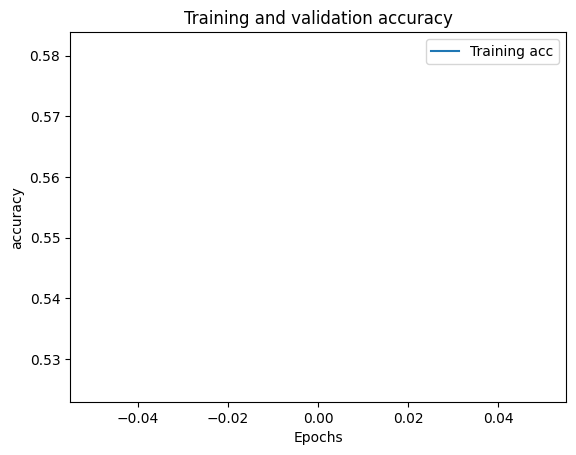

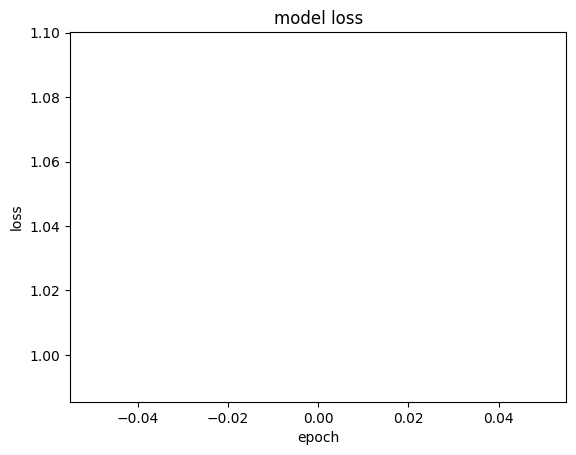

Testing
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Const): /job:localhost/replica:0/task:0/device:GPU:0
truediv/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_7/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_7/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_7/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_8/stack: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_8/stack_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_8/stack_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Const_7: (Const): /job:localhost/replica:0/task:0/device:GPU:0
strided_slice_9

2023-03-15 18:19:45.871495: I tensorflow/core/common_runtime/placer.cc:114] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:19:45.871532: I tensorflow/core/common_runtime/placer.cc:114] MapDataset: (MapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:19:45.871540: I tensorflow/core/common_runtime/placer.cc:114] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:19:45.873929: I tensorflow/core/common_runtime/placer.cc:114] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:19:45.873959: I tensorflow/core/common_runtime/placer.cc:114] buffer__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:19:45.873971: I tensorflow/core/common_runtime/placer.cc:114] PrefetchDataset: (PrefetchDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:19:45.873980: I tensorflow/core/common_runtime/placer.cc:114] handle_RetVal: (_Retval): /job:localhost

e:CPU:0
GatherV2_1/axis: (Const): /job:localhost/replica:0/task:0/device:CPU:0
iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
model_tf_bert_model_bert_embeddings_gather_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
model_tf_bert_model_bert_embeddings_gather_1_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
model_tf_bert_model_bert_embeddings_gather_2_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
model_tf_bert_model_bert_embeddings_layernorm_batchnorm_mul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
model_tf_bert_model_bert_embeddings_layernorm_batchnorm_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
model_tf_bert_model_bert_encoder_layer___0_attention_self_query_tensordot_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
model_tf_bert_model_bert_encoder_layer___0_attention_self_query_biasadd_readvariableop_resource: (_Arg): /job:lo

2023-03-15 18:22:20.838616: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:20.838653: I tensorflow/core/common_runtime/placer.cc:114] begin: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:20.838663: I tensorflow/core/common_runtime/placer.cc:114] end: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:20.838671: I tensorflow/core/common_runtime/placer.cc:114] strides: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:20.838683: I tensorflow/core/common_runtime/placer.cc:114] StridedSlice: (StridedSlice): /job:localhost/replica:0/task:0/device:GPU:0
2023-03-15 18:22:20.838692: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0


Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replic

2023-03-15 18:22:22.577315: I tensorflow/core/common_runtime/placer.cc:114] values_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:22.577361: I tensorflow/core/common_runtime/placer.cc:114] values_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:22.577373: I tensorflow/core/common_runtime/placer.cc:114] values_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:22.577382: I tensorflow/core/common_runtime/placer.cc:114] values_3: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:22.577391: I tensorflow/core/common_runtime/placer.cc:114] values_4: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:22.577399: I tensorflow/core/common_runtime/placer.cc:114] values_5: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:22.577408: I tensorflow/core/common_runtime/placer.cc:114] values_6: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:22.577416:

                          precision    recall  f1-score   support

      Admit to Inpatient       0.68      0.45      0.54      6608
               Discharge       0.59      0.84      0.70      7187
    Place in Observation       0.00      0.00      0.00       733
Place in Observation-CDU       0.00      0.00      0.00        87

                accuracy                           0.62     14615
               macro avg       0.32      0.32      0.31     14615
            weighted avg       0.60      0.62      0.59     14615

Validation
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localho

2023-03-15 18:22:26.531438: I tensorflow/core/common_runtime/placer.cc:114] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:26.531482: I tensorflow/core/common_runtime/placer.cc:114] MapDataset: (MapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:26.531489: I tensorflow/core/common_runtime/placer.cc:114] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:26.534237: I tensorflow/core/common_runtime/placer.cc:114] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:26.534270: I tensorflow/core/common_runtime/placer.cc:114] buffer__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:26.534280: I tensorflow/core/common_runtime/placer.cc:114] PrefetchDataset: (PrefetchDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:22:26.534287: I tensorflow/core/common_runtime/placer.cc:114] handle_RetVal: (_Retval): /job:localhost

  1/914 [..............................] - ETA: 5:19Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_39809 in device /job:localhost/replica:0/task:0/device:GPU:0
  2/914 [..............................] - ETA: 5:06Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_39809 in device /job:localhost/replica:0/task:0/device:GPU:0
  3/914 [..............................] - ETA: 5:10Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_39809 in device /job:localhost/replica:0/task:0/device:GPU:0
  4/914 [..............................] - ETA: 5:06Exe

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/repli

2023-03-15 18:27:35.187518: I tensorflow/core/common_runtime/placer.cc:114] values_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:27:35.187558: I tensorflow/core/common_runtime/placer.cc:114] values_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:27:35.187567: I tensorflow/core/common_runtime/placer.cc:114] values_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:27:35.187574: I tensorflow/core/common_runtime/placer.cc:114] values_3: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:27:35.187582: I tensorflow/core/common_runtime/placer.cc:114] values_4: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:27:35.187589: I tensorflow/core/common_runtime/placer.cc:114] values_5: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:27:35.187597: I tensorflow/core/common_runtime/placer.cc:114] values_6: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-15 18:27:35.187605:

Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0


/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/l2v/lib/python3.10/site-packages/s

                          precision    recall  f1-score   support

      Admit to Inpatient       0.68      0.45      0.54     13217
               Discharge       0.59      0.84      0.69     14295
    Place in Observation       0.00      0.00      0.00      1537
Place in Observation-CDU       0.00      0.00      0.00       181

                accuracy                           0.62     29230
               macro avg       0.32      0.32      0.31     29230
            weighted avg       0.60      0.62      0.58     29230



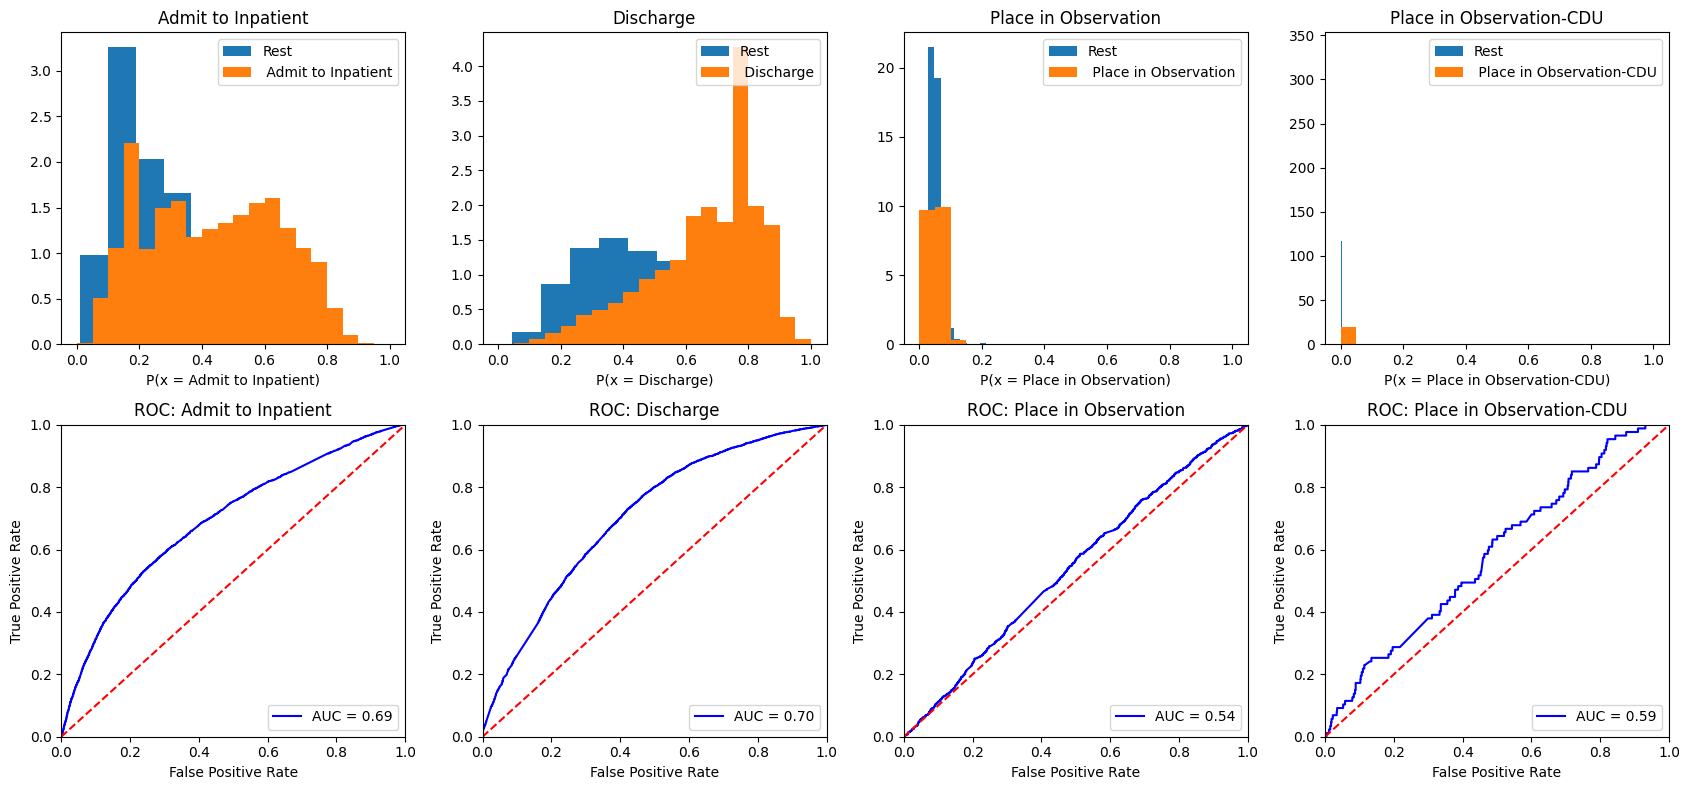

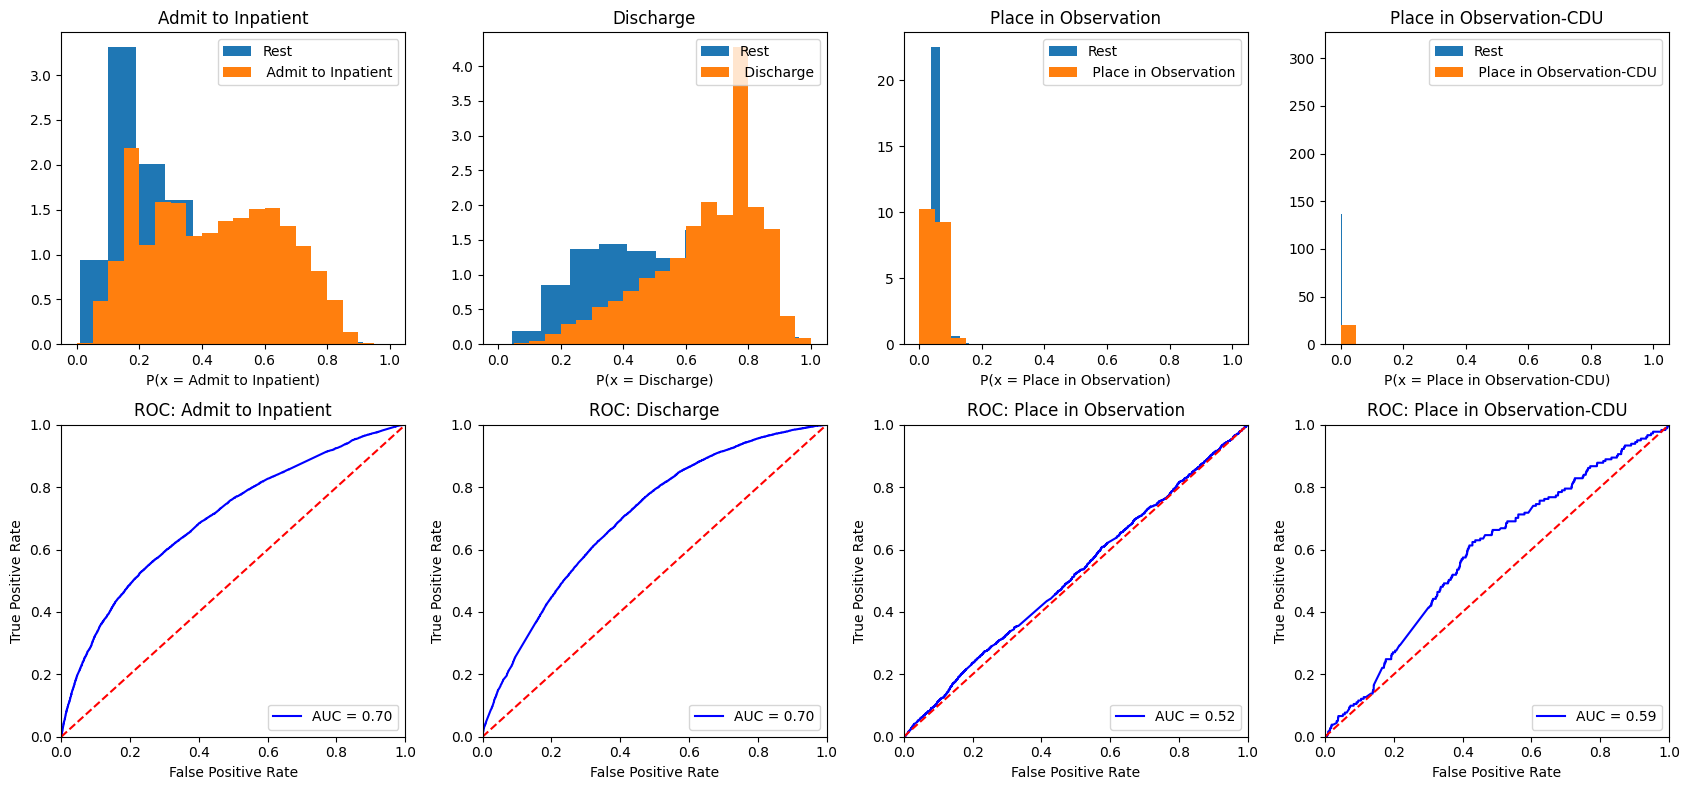

In [18]:
for parameter in dict_parameters:
    print(parameter)
    print('Training')
    with mlflow.start_run(): 
        mlflow_log_parameters(parameter) 
        bert_model = create_bert(bert, parameter['learning_rate'], parameter['dropout'])
        hist = bert_model.fit( x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']}, 
                     y=y_train, epochs=parameter['epochs'], batch_size=parameter['batch_size'])
    
        training_test_mae( mlflow, hist)
        
        print('Testing')
        split_type = 'test'
        y_pred = bert_model.predict(x = {'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']})
        accuracy, precision, recall, f1score = evaluate(y_test, y_pred, mlflow, split_type)
        
        print('Validation')
        split_type = 'validation'
        y_pred = bert_model.predict(x = {'input_ids':X_val['input_ids'], 'attention_mask':X_val['attention_mask']})
        accuracy, precision, recall, f1score = evaluate(y_val, y_pred, mlflow,  split_type)
        
        mlflow.end_run()